In [1]:
suppressPackageStartupMessages({
    library(jsonlite)
    library(dplyr)
    library(tidyr)
    library(tidyverse)
    remotes::install_github("christianholland/AachenColorPalette")
    library(AachenColorPalette)
    install.packages("gitlabr")
    library(gitlabr)
})

Skipping install of 'AachenColorPalette' from a github remote, the SHA1 (de03d4d4) has not changed since last install.
  Use `force = TRUE` to force installation

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
set_gitlab_connection(
  gitlab_url = "https://git.rwth-aachen.de",
  # create private access token with read_api permission here: `https://git.rwth-aachen.de/-/profile/personal_access_tokens` and paste that in `pat.txt`
  # PAT is stored in an external file to prevent accidental commiting this to a git repository...
  private_token = readLines("pat.txt", warn=FALSE)
)
# copy the project id from the project page `75304` is `https://git.rwth-aachen.de/coscine/reporting/reporting-database`
report_project_id <- 75304
# use the date to browse the history
report_date <- as.Date("2022-11-25")
# get all commits on the main branch
reporting_commits <- gl_get_commits(report_project_id, "", ref_name="main")
reporting_commits$created_at = as.Date(reporting_commits$created_at)
# filter for the given date
report_commit <- (reporting_commits %>% filter(created_at == report_date))[1]$id
# list files e.g. in `General` or for RWTH in `Organizations/04xfq0f34`
gl_list_files(report_project_id, path="General", ref=report_commit)

id                                       name                      type
1 966433eea55247fd377ad003c71b5e060f6db069 application_profiles.json blob
2 4f5b6d153f2d3dd806f51d77124b94b7524abf66 projects.json             blob
3 15822613723afc2a9db66273749aafa979557365 resources.json            blob
4 f19d4e26292cc28a3a42aa63d9ba8aecc8c83345 system_status.json        blob
5 d771a09528331dfc7add78b94dded7055cc96415 users.json                blob
  path                              mode  
1 General/application_profiles.json 100644
2 General/projects.json             100644
3 General/resources.json            100644
4 General/system_status.json        100644
5 General/users.json                100644

In [3]:
# request file using path from above. Note: here you need to replace `/` with `%2F`!
report_path <- "General%2Fresources.json"
resources_json <- gl_get_file(report_project_id, file_path=report_path, ref=report_commit)

In [4]:
# now parse the json into a dataframe `d`
d <- fromJSON(resources_json, simplifyVector = TRUE, simplifyDataFrame=TRUE, simplifyMatrix=TRUE, flatten=TRUE)

In [5]:
# lets see what resource types are used
unique(d$ResourceType)

[1] "rdss3rwth"     "rdss3nrw"      "rdsrwth"       "linked"       
[5] "rdsnrw"        "rdss3ude"      "rdss3wormrwth" "rdsude"       
[9] "s3"

In [6]:
# only consider a subset of resource types e.g. `rdsrwth` and `rdss3rwth`
rtfilter <- c('rdsrwth', 'rdss3rwth')
#rtfilter <- c('rdss3nrw', 'rdsnrw')

In [7]:
# filter only a subset of resources in `df`
df <- d %>% filter(ResourceType %in% rtfilter)
# `Disciplines` is a multi-value field using `unnest` into `dfu` create one row for each occurance:
# 1; [A ,B]
# 2; [C]
# yields
# 1; A
# 1; B
# 2; C
dfu <- df %>% unnest(Disciplines, names_sep='.')

In [8]:
head(df, 2)
head(dfu, 2)

Id                                   ResourceType DateCreated Archived
1 af80711b-0de5-43e6-a5ba-0006d053489a rdss3rwth    NA           TRUE   
2 ac26c45a-c200-4304-8154-001e2b3b72b8 rdss3rwth    NA          FALSE   
  Deleted MetadataVisibilityId                
1 FALSE   8ab9c883-eb0d-4402-aaad-2e4007badce6
2 FALSE   8ab9c883-eb0d-4402-aaad-2e4007badce6
  RelatedProjectId                    
1 c92e2deb-085c-490b-aed3-5a6b9a4c8859
2 806d260f-0a08-490f-a06c-679edaa31831
  Organizations                                                                                                                                                                                 
1 NULL                                                                                                                                                                                          
2 Bonn-Rhein-Sieg University of Applied Sciences, IT Center                                     , https://ror.org/04m2anh63                     , https://ror.org/04xfq0f34#ORG-42NHW           
  Disciplines                                                                                                                                                                                                                                                                                               
1 cfd6b656-f4ba-48c6-b5d8-2f98a7b60d1f                                     , http://www.dfg.de/dfg_profil/gremien/fachkollegien/liste/index.jsp?id=409, Informatik 409                                                           , Computer Science 409                                                     
2 cfd6b656-f4ba-48c6-b5d8-2f98a7b60d1f                                     , http://www.dfg.de/dfg_profil/gremien/fachkollegien/liste/index.jsp?id=409, Informatik 409                                                           , Computer Science 409                                                     
  License     ApplicationProfile                
1 MIT License https://purl.org/coscine/ap/radar/
2 NA          https://purl.org/coscine/ap/radar/
  ResourceQuota.Id                     ResourceQuota.Name       
1 af80711b-0de5-43e6-a5ba-0006d053489a SA_home_bhat.7z.001      
2 ac26c45a-c200-4304-8154-001e2b3b72b8 Zertifikatskurs Forschung
  ResourceQuota.UsedPercentage ResourceQuota.Used.Value
1 65.1041700                   2097152000              
2  0.2439657                      2619562              
  ResourceQuota.Used.Unit          ResourceQuota.Reserved.Value
1 https://qudt.org/vocab/unit/BYTE 3                           
2 https://qudt.org/vocab/unit/BYTE 1                           
  ResourceQuota.Reserved.Unit         
1 https://qudt.org/vocab/unit/GibiBYTE
2 https://qudt.org/vocab/unit/GibiBYTE

Id                                   ResourceType DateCreated Archived
1 af80711b-0de5-43e6-a5ba-0006d053489a rdss3rwth    NA           TRUE   
2 ac26c45a-c200-4304-8154-001e2b3b72b8 rdss3rwth    NA          FALSE   
  Deleted MetadataVisibilityId                
1 FALSE   8ab9c883-eb0d-4402-aaad-2e4007badce6
2 FALSE   8ab9c883-eb0d-4402-aaad-2e4007badce6
  RelatedProjectId                    
1 c92e2deb-085c-490b-aed3-5a6b9a4c8859
2 806d260f-0a08-490f-a06c-679edaa31831
  Organizations                                                                                                                                                                                 
1 NULL                                                                                                                                                                                          
2 Bonn-Rhein-Sieg University of Applied Sciences, IT Center                                     , https://ror.org/04m2anh63                     , https://ror.org/04xfq0f34#ORG-42NHW           
  Disciplines.Id                      
1 cfd6b656-f4ba-48c6-b5d8-2f98a7b60d1f
2 cfd6b656-f4ba-48c6-b5d8-2f98a7b60d1f
  Disciplines.Url                                                           ⋯
1 http://www.dfg.de/dfg_profil/gremien/fachkollegien/liste/index.jsp?id=409 ⋯
2 http://www.dfg.de/dfg_profil/gremien/fachkollegien/liste/index.jsp?id=409 ⋯
  Disciplines.DisplayNameEn License     ApplicationProfile                
1 Computer Science 409      MIT License https://purl.org/coscine/ap/radar/
2 Computer Science 409      NA          https://purl.org/coscine/ap/radar/
  ResourceQuota.Id                     ResourceQuota.Name       
1 af80711b-0de5-43e6-a5ba-0006d053489a SA_home_bhat.7z.001      
2 ac26c45a-c200-4304-8154-001e2b3b72b8 Zertifikatskurs Forschung
  ResourceQuota.UsedPercentage ResourceQuota.Used.Value
1 65.1041700                   2097152000              
2  0.2439657                      2619562              
  ResourceQuota.Used.Unit          ResourceQuota.Reserved.Value
1 https://qudt.org/vocab/unit/BYTE 3                           
2 https://qudt.org/vocab/unit/BYTE 1                           
  ResourceQuota.Reserved.Unit         
1 https://qudt.org/vocab/unit/GibiBYTE
2 https://qudt.org/vocab/unit/GibiBYTE

In [9]:
# total sum of currently claimes space by resources (using `df` to not count doubled rows by `unnest`)
df %>% summarise(totalTB=sum(ResourceQuota.Reserved.Value)/1024)

totalTB
1 819.168

In [10]:
# lets see the disciplines using our storage so group by discipline and sum up reseved quota into `dfug`
dfug <- dfu %>% 
    group_by(Disciplines.DisplayNameDe) %>%
    # sum up and convert GB to TB
    summarise(totalTB=sum(ResourceQuota.Reserved.Value)/1024) %>%
    arrange(desc(totalTB))
nrow(dfug)
head(dfug,2)

[1] 45

Disciplines.DisplayNameDe totalTB
1 Informatik 409            296.083
2 Medizin 205               231.876

In [11]:
# for plotting group small disciplines below a certain usage in their own `other` category
groupbelowTB <- 5
dfug_other <- dfug %>% filter(totalTB < groupbelowTB) %>% summarise(totalTB=sum(totalTB))
dfug_other$Disciplines.DisplayNameDe <- 'Andere'

# all others go to the top
dfug_top <- dfug %>% filter(totalTB > groupbelowTB)

# make nice labels showing the sum
dfug_top$label <- sprintf("%s (%.2f TB)", str_sub(dfug_top$Disciplines.DisplayNameDe, 0,-4), dfug_top$totalTB)
dfug_other$label <- sprintf('Andere (%.2f TB)', dfug_other$totalTB)

# merge top and other together
dfug_total <- rbind(dfug_top, dfug_other)
# generate an id column to keep the current sorting `top1, top2 ... other`
dfug_total$id <- seq(1,nrow(dfug_total))
dfug_total

Disciplines.DisplayNameDe                                        totalTB   
1  Informatik 409                                                   296.083008
2  Medizin 205                                                      231.875977
3  Mechanik und Konstruktiver Maschinenbau 402                      122.878906
4  Physikalische und Theoretische Chemie 303                         56.434570
5  Polymerforschung 306                                              35.382812
6  Wärmeenergietechnik, Thermische Maschinen, Strömungsmechanik 404  27.577148
7  Verfahrenstechnik, Technische Chemie 403                          20.847656
8  Produktionstechnik 401                                            11.973633
9  Grundlagen der Biologie und Medizin 201                           10.067383
10 Elektrotechnik und Informationstechnik 408                         8.886719
11 Materialwissenschaft 406                                           7.834961
12 Andere                                                             7.259766
   label                                                                    id
1  Informatik  (296.08 TB)                                                   1
2  Medizin  (231.88 TB)                                                      2
3  Mechanik und Konstruktiver Maschinenbau  (122.88 TB)                      3
4  Physikalische und Theoretische Chemie  (56.43 TB)                         4
5  Polymerforschung  (35.38 TB)                                              5
6  Wärmeenergietechnik, Thermische Maschinen, Strömungsmechanik  (27.58 TB)  6
7  Verfahrenstechnik, Technische Chemie  (20.85 TB)                          7
8  Produktionstechnik  (11.97 TB)                                            8
9  Grundlagen der Biologie und Medizin  (10.07 TB)                           9
10 Elektrotechnik und Informationstechnik  (8.89 TB)                        10
11 Materialwissenschaft  (7.83 TB)                                          11
12 Andere (7.26 TB)                                                         12

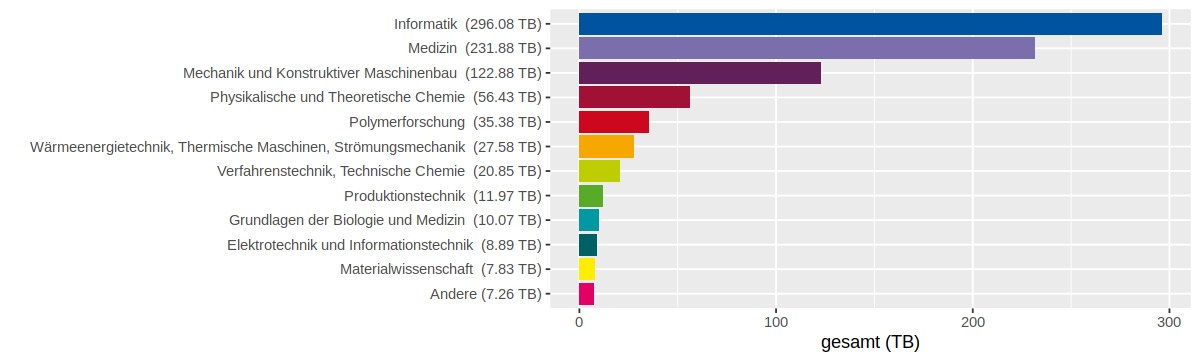

In [12]:
options(repr.plot.width=10, repr.plot.height=3)
# now plot...
ggplot(dfug_total,
    # order labels by generated id, and plot totalTB
    aes(x=reorder(label, -id), y=totalTB, fill=factor(id))) +
    geom_bar(stat="identity", show.legend = FALSE) +
    # colors!
    scale_fill_manual(values = aachen_color("blue", "purple", "violet", "bordeaux", "red", "orange", "maygreen", "green", "turquoise", "petrol", "yellow", "magenta")) +
    coord_flip() +
    ylab("gesamt (TB)") + 
    xlab("")

In [13]:
# generate a nice filename based on the settings above
filename <- paste('plot', report_date, gsub("%2F", "-", gsub(".json", "", report_path)), paste(rtfilter, collapse="-"), ".png", sep="_")
filename
# save plot
ggsave(filename, width=10, height=3)


[1] "plot_2022-11-25_General-resources_rdsrwth-rdss3rwth_.png"